<a href="https://colab.research.google.com/github/inuwamobarak/african_atire_dictator/blob/main/Attempt_on_African_attire_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

stuck accuracy approzimately 50%



---



In [ ]:
#magic function for matplotlib graphs. Graphs will be included in notebook next to the code. 
%matplotlib inline

In [ ]:
#importing dependencies
from __future__ import print_function, division

from datetime import datetime
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data
---------


In [ ]:
#Dataset from drive 
DATA_FILE = "/content/drive/MyDrive/MLProjects/dataset/african_atires"
train_dataset = "/content/drive/MyDrive/Datasets/dataset/african_atires/Train/"
val_dataset = "/content/drive/MyDrive/Datasets/dataset/african_atires/Validation/"

Data Cleaning

In [ ]:
from pathlib import Path
import imghdr

data_dir = DATA_FILE # "/content/drive/MyDrive/MLProjects/dataset/african_atire/"
image_extensions = [".png", ".svg", ".gif", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted images")

#Data transformation

In [ ]:
#changing the format and structure of the data.
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = DATA_FILE
data_types = ['Train', 'Validation']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in data_types}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in data_types}
dataset_sizes = {x: len(image_datasets[x]) for x in data_types}
class_names = image_datasets['Train'].classes

#checking for available processor 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Visualization

With the help of data visualization, we can see how the data looks and what we are dealing with from the image. 



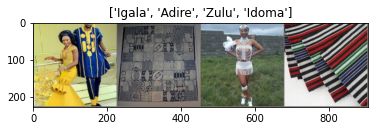

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
print("List of Directories:", os.listdir(data_dir))
classes = os.listdir(data_dir + "/Train")
print("List of classes:", classes)

List of Directories: ['Train', 'Validation']
List of classes: ['Idoma', 'Zulu', 'Tswana-Shweshwe', 'Tiv', 'Igala', 'Idgo', 'Adire', 'Xhosa-South Africa']


In [ ]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
import random
random_value = random.randint(1, 800)
show_example(*train_dataset[2])

TypeError: ignored

In [ ]:
random_value = random.randint(1, 50)
show_example(*train_dataset[random_value])

TypeError: ignored

In [ ]:
random_value = random.randint(1, 2000)
show_example(*train_dataset[random_value])

IndexError: ignored

In [ ]:
random_value = random.randint(1, 2000)
show_example(*train_dataset[random_value])

IndexError: ignored


#Tensorboarding

In [ ]:
#tensorboard logging
#to track various metrics such as accuracy and log loss on training or validation set
from torch.utils.tensorboard import SummaryWriter

TB_DIR = f'runs/exp_{datetime.now().strftime("%Y%m%d-%H%M%S")}'  
tb_train_writer = SummaryWriter(f'{TB_DIR}/Train')
tb_val_writer = SummaryWriter(f'{TB_DIR}/Validation')

%load_ext tensorboard

#Model Building


Helper function for training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=4):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'Train':
              tb_writer = tb_train_writer
            else:
              tb_writer = tb_val_writer

            tb_writer.add_scalar(f'Loss', epoch_loss, epoch)
            tb_writer.add_scalar(f'Accuracy', epoch_acc, epoch)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    tb_train_writer.close()
    tb_val_writer.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing Predictions



In [ ]:
def visualize_model(model, dataset, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[dataset]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

##Finetuning the Convnet
----------------------
Load a pretrained model and reset final fully connected layer.


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to number of classes.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Training and evaluation




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=24)

Epoch 0/23
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.9094 Acc: 0.7050
Validation Loss: 5.0017 Acc: 0.4550

Epoch 1/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.6199 Acc: 0.8048
Validation Loss: 5.4219 Acc: 0.4984

Epoch 2/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.4822 Acc: 0.8493
Validation Loss: 6.4376 Acc: 0.4760

Epoch 3/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.4078 Acc: 0.8759
Validation Loss: 5.8308 Acc: 0.4748

Epoch 4/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3153 Acc: 0.9018
Validation Loss: 6.1894 Acc: 0.5085

Epoch 5/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2721 Acc: 0.9133
Validation Loss: 5.3384 Acc: 0.5039

Epoch 6/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2435 Acc: 0.9304
Validation Loss: 5.5488 Acc: 0.4957

Epoch 7/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1427 Acc: 0.9610
Validation Loss: 5.5125 Acc: 0.5050

Epoch 8/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1040 Acc: 0.9715
Validation Loss: 5.9554 Acc: 0.5093

Epoch 9/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0931 Acc: 0.9745
Validation Loss: 5.9414 Acc: 0.5062

Epoch 10/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0998 Acc: 0.9719
Validation Loss: 5.4425 Acc: 0.5093

Epoch 11/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0802 Acc: 0.9797
Validation Loss: 5.4063 Acc: 0.5101

Epoch 12/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0673 Acc: 0.9822
Validation Loss: 5.4766 Acc: 0.5105

Epoch 13/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0636 Acc: 0.9821
Validation Loss: 5.4198 Acc: 0.5136

Epoch 14/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0661 Acc: 0.9819
Validation Loss: 5.7225 Acc: 0.5140

Epoch 15/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0640 Acc: 0.9831
Validation Loss: 5.5556 Acc: 0.5159

Epoch 16/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0666 Acc: 0.9831
Validation Loss: 5.5762 Acc: 0.5147

Epoch 17/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0596 Acc: 0.9837
Validation Loss: 5.4863 Acc: 0.5155

Epoch 18/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0653 Acc: 0.9829
Validation Loss: 5.4856 Acc: 0.5163

Epoch 19/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0624 Acc: 0.9827
Validation Loss: 5.4184 Acc: 0.5147

Epoch 20/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0563 Acc: 0.9842
Validation Loss: 5.6183 Acc: 0.5143

Epoch 21/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0656 Acc: 0.9831
Validation Loss: 5.7027 Acc: 0.5155

Epoch 22/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0683 Acc: 0.9822
Validation Loss: 5.5706 Acc: 0.5182

Epoch 23/23
----------


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0621 Acc: 0.9830
Validation Loss: 5.8770 Acc: 0.5093

Training complete in 55m 53s
Best val Acc: 0.518217


#Showing TensorBoard for metrices learnt

In [ ]:
%tensorboard --logdir='./runs'

# Model Testing

In [ ]:
def check_accuracy(test_loader, model, device):
    num_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device=device)
            labels = labels.to(device=device)

            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            num_correct += (predictions == labels).sum()
            total += labels.size(0)
        print(f"Test Accuracy of the model: {float(num_correct)/float(total):.2f}")

def visualize_test_errors(test_loader, model, device):
    model.eval()
    incorrect_examples=[]

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device=device)
            labels = labels.to(device=device)

            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            idxs_mask = (predictions != labels).view(-1)
            num_true_idxs = idxs_mask.sum() 
            if num_true_idxs > 0:
                found_falses = data[idxs_mask].cpu().numpy()
                false_predictions = predictions[idxs_mask].cpu().numpy()
                false_labels = labels[idxs_mask].cpu().numpy()
                for j in range(found_falses.shape[0]):
                    incorrect_examples.append((found_falses[j,:,:,:], 
                                               false_predictions[j],
                                               false_labels[j]))
    return incorrect_examples

def show_image(inp, title=None):
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

def visualize_error_images(error_examples):
    for img, prediction, label in error_examples:
        print(f'gt label: {class_names[label]}')
        print(f'prediction: {class_names[prediction]}')
        show_image(img.squeeze())


In [ ]:
error_images = check_accuracy(dataloaders['Validation'], model_ft, device)

error_examples = visualize_test_errors(dataloaders['Validation'], model_ft, device)
#shows some prediction errors. Might show nothing if prediction is 100%
visualize_error_images(error_examples)

# Model Saving

In [ ]:
torch.save(model_ft, 'modelv_1_0.pt')